## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [13]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="sigmoid", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="sigmoid", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="sigmoid", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 512
MOMENTUM = 0.85
L_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [19]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l2(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 253us/step - loss: 2.3994 - acc: 0.1466 - val_loss: 2.3508 - val_acc: 0.1792
Epoch 2/50
50000/50000 [==============================] - 12s 243us/step - loss: 2.3025 - acc: 0.2209 - val_loss: 2.2498 - val_acc: 0.2587
Epoch 3/50
50000/50000 [==============================] - 12s 242us/step - loss: 2.2002 - acc: 0.2753 - val_loss: 2.1532 - val_acc: 0.2958
Epoch 4/50
50000/50000 [==============================] - 13s 253us/step - loss: 2.1184 - acc: 0.3075 - val_loss: 2.0880 - val_acc: 0.3234
Epoch 5/50
50000/50000 [==============================] - 12s 246us/step - loss: 2.0638 - acc: 0.3284 - val_loss: 2.0445 - val_acc: 0.3371
Epoch 6/50
50000/50000 [==============================] - 12s 243us/step - loss: 2.0261 - acc: 0.3399 - val_loss: 2.0147 - val_acc: 0.3450
Epoch 7/50
50000/50000 [==============================] - 12s 242us/step - loss: 1.9984 - acc: 0.3504 - val_loss: 1.

50000/50000 [==============================] - 13s 252us/step - loss: 2.2796 - acc: 0.1437 - val_loss: 2.2469 - val_acc: 0.1873
Epoch 2/50
50000/50000 [==============================] - 12s 243us/step - loss: 2.2155 - acc: 0.2171 - val_loss: 2.1823 - val_acc: 0.2433
Epoch 3/50
50000/50000 [==============================] - 12s 246us/step - loss: 2.1383 - acc: 0.2577 - val_loss: 2.0940 - val_acc: 0.2721
Epoch 4/50
50000/50000 [==============================] - 12s 244us/step - loss: 2.0436 - acc: 0.2848 - val_loss: 1.9991 - val_acc: 0.2957
Epoch 5/50
50000/50000 [==============================] - 12s 243us/step - loss: 1.9637 - acc: 0.3066 - val_loss: 1.9348 - val_acc: 0.3192
Epoch 6/50
50000/50000 [==============================] - 12s 242us/step - loss: 1.9110 - acc: 0.3259 - val_loss: 1.8908 - val_acc: 0.3367
Epoch 7/50
50000/50000 [==============================] - 12s 242us/step - loss: 1.8745 - acc: 0.3397 - val_loss: 1.8652 - val_acc: 0.3470
Epoch 8/50
50000/50000 [==============

Epoch 2/50
50000/50000 [==============================] - 13s 257us/step - loss: 2.2126 - acc: 0.2184 - val_loss: 2.1793 - val_acc: 0.2293
Epoch 3/50
50000/50000 [==============================] - 13s 259us/step - loss: 2.1379 - acc: 0.2436 - val_loss: 2.0958 - val_acc: 0.2488
Epoch 4/50
50000/50000 [==============================] - 12s 242us/step - loss: 2.0522 - acc: 0.2735 - val_loss: 2.0120 - val_acc: 0.2875
Epoch 5/50
50000/50000 [==============================] - 12s 242us/step - loss: 1.9763 - acc: 0.3037 - val_loss: 1.9438 - val_acc: 0.3130
Epoch 6/50
50000/50000 [==============================] - 12s 242us/step - loss: 1.9188 - acc: 0.3236 - val_loss: 1.8981 - val_acc: 0.3342
Epoch 7/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.8812 - acc: 0.3392 - val_loss: 1.8682 - val_acc: 0.3430
Epoch 8/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.8533 - acc: 0.3485 - val_loss: 1.8470 - val_acc: 0.3479
Epoch 9/50
50000/50000 [===

#### L2

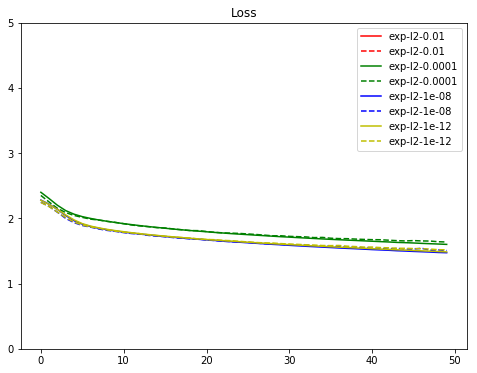

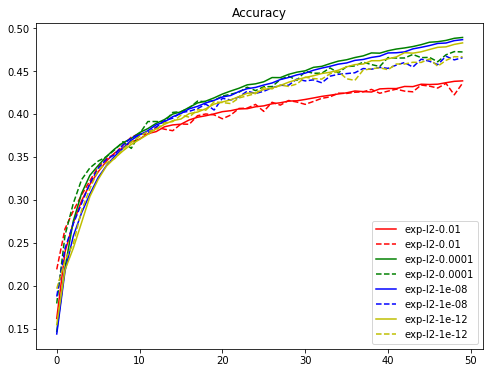

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### L1

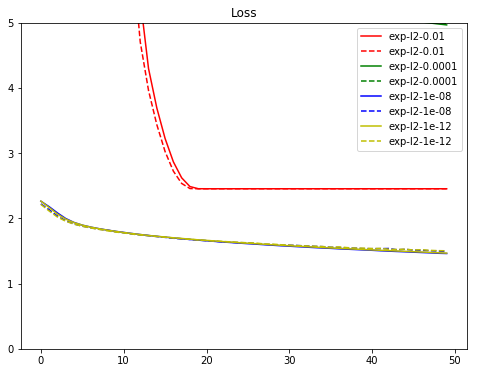

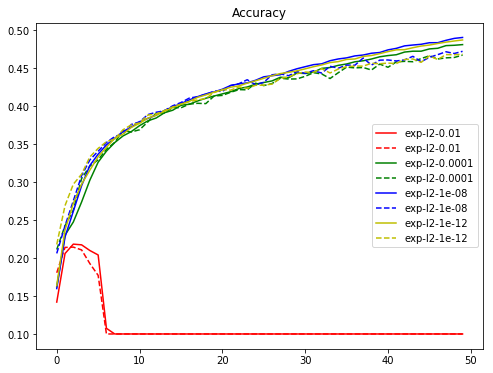

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [18]:
# L1
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 3s 274us/step
Test loss: 1.502343239593506
Test accuracy: 0.468


In [21]:
# L2
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 248us/step
Test loss: 1.5168162403106689
Test accuracy: 0.4663
